## Read model

In [11]:
from pathlib import Path
import toml
import torch

from utils.config import *
from model.unet import Unet
from diffusion.diffusion import DiffusionModel

experiment_directory = Path("experiments/model_3")

device = "cuda" if torch.cuda.is_available() else "cpu"

config_toml = experiment_directory / "config.toml"
with open(config_toml, 'r') as f:
    config = toml.load(f)

unet_config = UnetConfig.parse_obj(config["Unet"])
diffusion_config = DiffusionConfig.parse_obj(config["Diffusion"])

model_path = experiment_directory / "best_loss" / "denoiser_unet.pt"

model = Unet(**unet_config.model_dump())
model.load_state_dict(torch.load(model_path, weights_only=True))
model.to(device)
model.eval()

ddpm = DiffusionModel(model, diffusion_config, device, experiment_directory)

## Check for overfitting

In [ ]:
psnr_in_train, psnr_out_train = ddpm.compute_psnr(train_loader, psnr_step=50)
psnr_in_val, psnr_out_val = ddpm.compute_psnr(val_loader, psnr_step=50)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(psnr_in_train, psnr_out_train, marker='o')
plt.plot(psnr_in_train, psnr_in_train, linestyle='--', c='k')
plt.plot(psnr_in_val, psnr_out_val, marker='o')
plt.show()

## Sample images

In [12]:
from diffusion.sampler import sample

# sample 64 images
samples = sample(ddpm, image_size=unet_config.dim, batch_size=64, channels=unet_config.channels)

1000


sampling loop time step: 100%|##########| 1000/1000 [01:08<00:00, 14.61it/s]


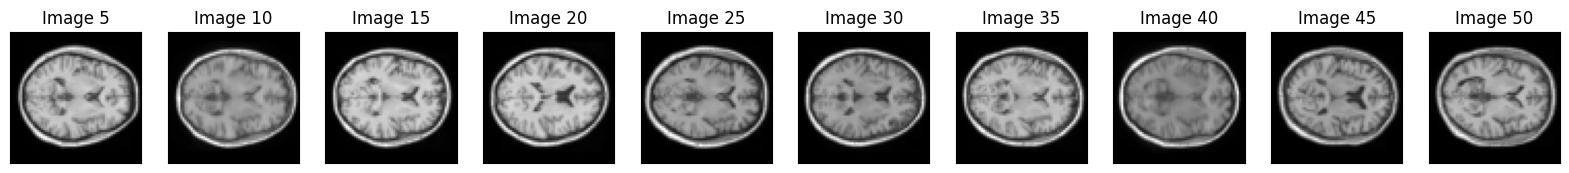

In [13]:
import matplotlib.pyplot as plt

# show 10 random ones
random_indexes = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

fig, axs = plt.subplots(1, 10, figsize=(20, 8))
for i in range(10):
    idx = random_indexes[i]
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
    axs[i].set_title(f"Image {idx}")
    axs[i].imshow(samples[-1][idx].reshape(unet_config.dim, unet_config.dim, unet_config.channels), cmap="gray")
plt.show()
fig.savefig(experiment_directory / "samples.pdf", format="pdf", bbox_inches="tight") 

## Make gif

In [ ]:
import matplotlib.animation as animation

random_index = 5

fig = plt.figure()
ims = []
for i in range(timesteps):
    plt.title(f"T = {i}")
    im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
animate.save('diffusion64x64.gif')
plt.show()